In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from itertools import combinations, chain

from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, RocCurveDisplay, auc

from joblib import dump
from imblearn.over_sampling import SMOTE


In [45]:
data = pd.read_csv(
    '../../../DATA/Concatination_of_ters/Without_Индекс стоимости жизни/classes.csv').dropna()

X, y = data.drop('Средняя численность работников, включая внешних совместителей',
                 axis=1), data['Средняя численность работников, включая внешних совместителей']
X_balanced, y_balanced = SMOTE().fit_resample(X, y)

X_balanced['Средняя численность работников, включая внешних совместителей'] = y_balanced

data_smoted = X_balanced
X_train_smoted, X_test_smoted, y_train_smoted, y_test_smoted = train_test_split(data_smoted.drop('Средняя численность работников, включая внешних совместителей', axis=1),
                                                                                data_smoted['Средняя численность работников, включая внешних совместителей'], test_size=0.5, random_state=0)


In [46]:
cbc = CatBoostClassifier(learning_rate=0.05,
                         task_type="GPU",
                         devices='0:4',
                         logging_level='Silent'
                         )


In [47]:
params = {'depth': np.arange(3, 10),
          'l2_leaf_reg': np.arange(1, 20),
          'bootstrap_type': ['Bayesian', 'Bernoulli', 'Poisson'],
          # 'leaf_estimation_method': [],
          'num_trees': np.arange(1, 20),
          #   'n_estimators': np.arange(3, 20),
          #   'num_boost_round': np.arange(1, 20),
          }
catboost_classifier_best_params = cbc.randomized_search(
    params, X=X_train_smoted[:1000], y=y_train_smoted[:1000], n_iter=3)

catboost_classifier_best_params['params']


0:	loss: 0.6452906	best: 0.6452906 (0)	total: 267ms	remaining: 534ms
1:	loss: 0.6318650	best: 0.6318650 (1)	total: 595ms	remaining: 298ms
2:	loss: 0.6233488	best: 0.6233488 (2)	total: 923ms	remaining: 0us
Estimating final quality...


{'depth': 8, 'l2_leaf_reg': 8, 'iterations': 6, 'bootstrap_type': 'Bernoulli'}

In [48]:
cbc.fit(X_train_smoted, y_train_smoted)


In [49]:
y_predicted = cbc.predict(X_test_smoted).astype('bool')


In [50]:
print(confusion_matrix(y_test_smoted, y_predicted))


[[ 0 45]
 [ 0 43]]


In [51]:
print(classification_report(y_test_smoted, y_predicted))


              precision    recall  f1-score   support

       False       0.00      0.00      0.00        45
        True       0.49      1.00      0.66        43

    accuracy                           0.49        88
   macro avg       0.24      0.50      0.33        88
weighted avg       0.24      0.49      0.32        88



c:\Users\Mike\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mike\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mike\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

c:\Users\Mike\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


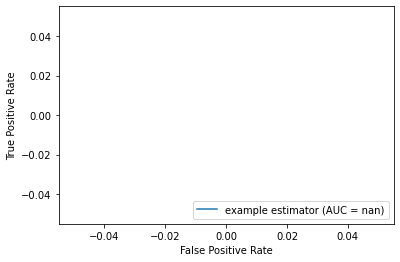

In [52]:
fpr, tpr, thresholds = roc_curve(y_predicted, y_test_smoted)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()


In [54]:
fpr, tpr


(array([nan, nan, nan]), array([0.        , 0.48863636, 1.        ]))